In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 출처
https://pytorch.org/tutorials/beginner/ddp_series_intro.html?utm_source=distr_landing&utm_medium=ddp_series_intro


# DISTRIBUTED DATA PARALLEL IN PYTORCH - VIDEO TUTORIALS 
https://pytorch.org/tutorials/beginner/ddp_series_intro.html?utm_source=distr_landing&utm_medium=ddp_series_intro




## 0. Introduction
Why use distributedtraining?
1. saves time (faster comutation)
1. larger model



will scale things up to
1. one node, one gpu
1. one node, multiple gpu
2. multiple node, multiple gpu

## 1. WHAT IS DISTRIBUTED DATA PARALLEL (DDP)

when DDP into 4 gpus :
1. 4 replicas of the model/optimizer (even the same seed) (4 processes)
    * these 4 replicas are kept same across the traning
    * **only thing different** : sample that is fed into the data
        * DataLoader 에서 **DistributedSampler**을 써서, make sure 4 gpus get different data, so we get 4x faster
        * different data for each model => different loss/gradient => DDP initiaites "synchronize" (all-reduce/bucket)을 함 => single gradient로 얻기 => optimize 4개를 하기 (updated to be the same model)
        * does informaiton pass while the backward is running (somehow)
        * all reduce algorithm : overlaps gradient computatino with communication (i.e. synchronization step doens't wait for all the gradient to be computed => GPU not idle, always working)
        
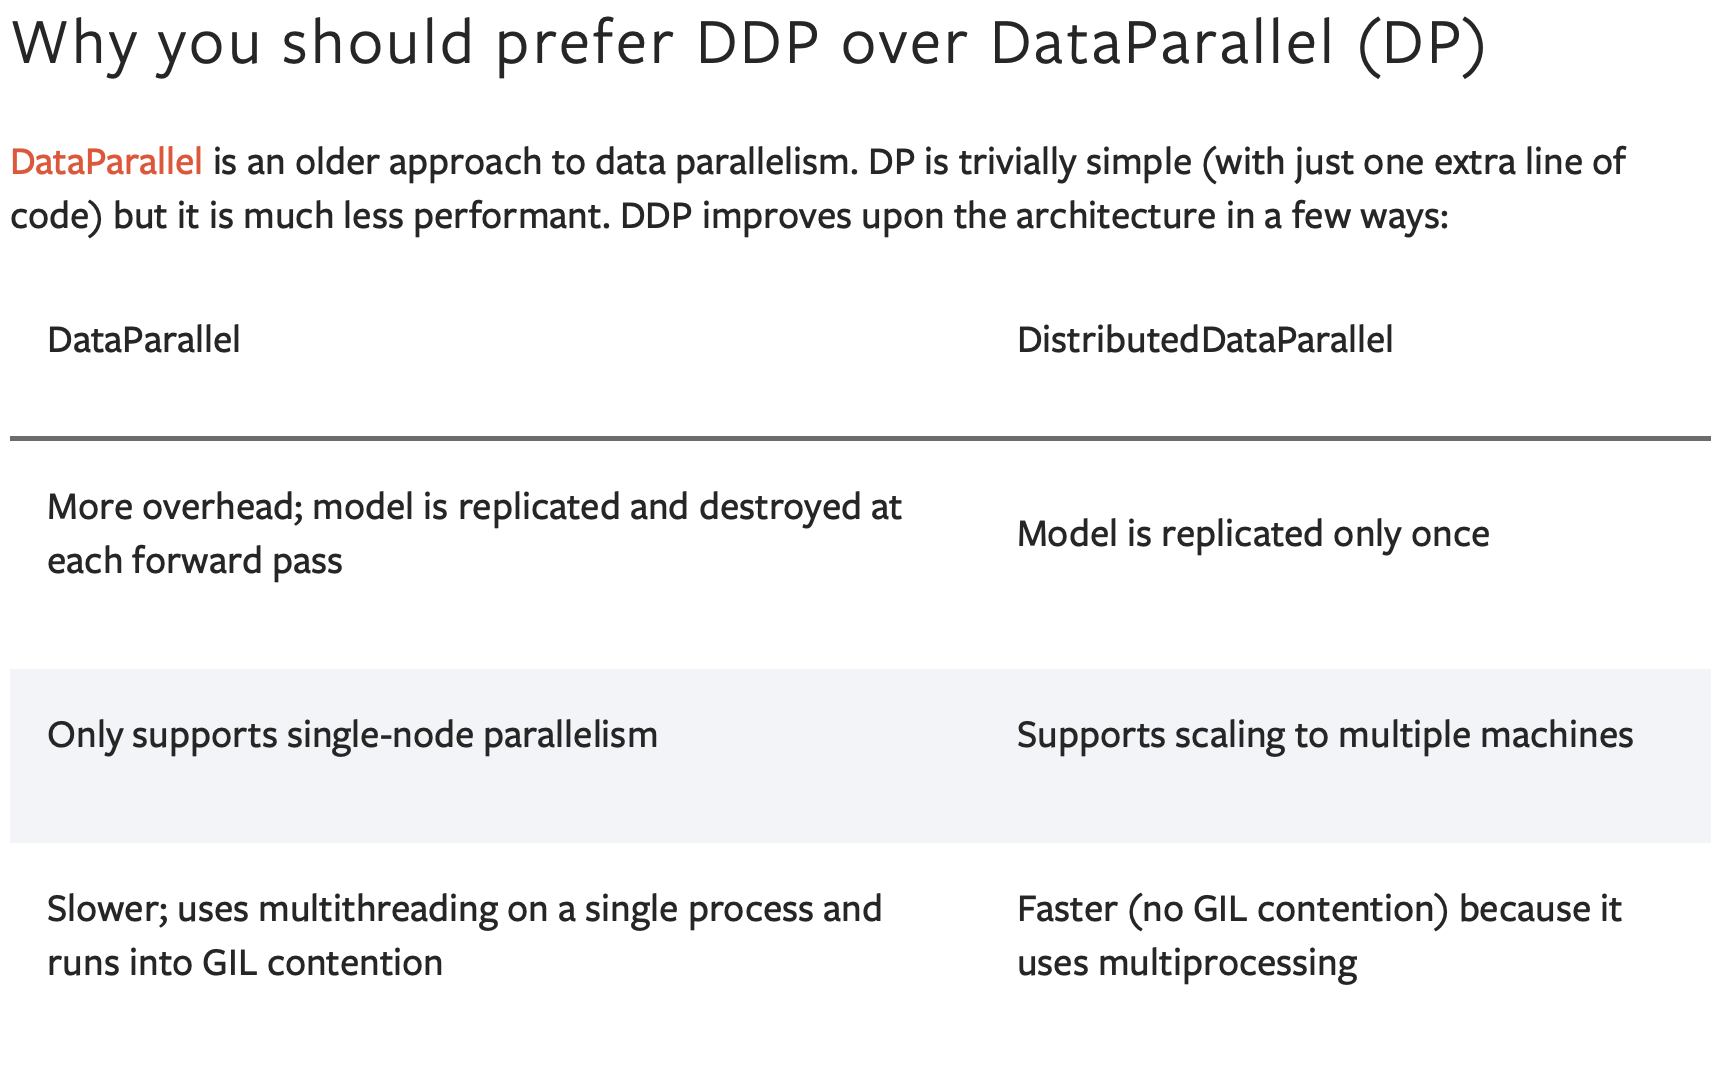

##  XXX common code : 

In [2]:
import torch
from torch.utils.data import Dataset

class MyTrainDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.data = [(torch.rand(20), torch.rand(1)) for _ in range(size)]

    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return self.data[index]

## 2. Multi GPU training with DDP 

### 2.1. Singe GPU로 돌려보는 것 해보자 (구체적 설명 생략)

In [3]:
!python single_gpu.py 100 3

[GPU0] Epoch 0 | Batchsize: 32 | Steps: 64
Epoch 0 | Training checkpoint saved at checkpoint.pt
[GPU0] Epoch 1 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 2 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 3 | Batchsize: 32 | Steps: 64
Epoch 3 | Training checkpoint saved at checkpoint.pt
[GPU0] Epoch 4 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 5 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 6 | Batchsize: 32 | Steps: 64
Epoch 6 | Training checkpoint saved at checkpoint.pt
[GPU0] Epoch 7 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 8 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 9 | Batchsize: 32 | Steps: 64
Epoch 9 | Training checkpoint saved at checkpoint.pt
[GPU0] Epoch 10 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 11 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 12 | Batchsize: 32 | Steps: 64
Epoch 12 | Training checkpoint saved at checkpoint.pt
[GPU0] Epoch 13 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 14 | Batchsize: 32 | Steps: 64
[GPU0] Epoch 15 | Batchsize: 32 | Steps: 64
Epoch 15 | Training checkpoint saved at 

###  2.2. Multi GPU로 돌려보는 것 해보자
(위의 것을 MultiGPU로 하자)

그냥 그 multiplegpu.py를 보기

밑의 것들 설명
* `torch.multiprocessing` : python의 default multiprocessing의 wrapper (added additional features)
* `DistributedSampler` : takes in our input data and distributes it across all our GPUs
* `DistributedDAtaParllel` (DDP) : our workhorse
* `init_process_gropu.`...?? 

* world size : # of total processes
* rank : # we assign to each process (usually, 0 ~ worldsize-1)


In [4]:
#mp.spawn이 정확히 뭐하는 건지 밑에서 보자 : 
#즉, fn 함수(main)을 돌리되, 그 함수에  args input을 넣어주고, nprocs개를 돌린다. 
import torch.multiprocessing as mp
help(mp.spawn)

Help on function spawn in module torch.multiprocessing.spawn:

spawn(fn, args=(), nprocs=1, join=True, daemon=False, start_method='spawn')
    Spawns ``nprocs`` processes that run ``fn`` with ``args``.
    
    If one of the processes exits with a non-zero exit status, the
    remaining processes are killed and an exception is raised with the
    cause of termination. In the case an exception was caught in the
    child process, it is forwarded and its traceback is included in
    the exception raised in the parent process.
    
    Args:
        fn (function): Function is called as the entrypoint of the
            spawned process. This function must be defined at the top
            level of a module so it can be pickled and spawned. This
            is a requirement imposed by multiprocessing.
    
            The function is called as ``fn(i, *args)``, where ``i`` is
            the process index and ``args`` is the passed through tuple
            of arguments.
    
        args (

In [5]:
!python multigpu.py 100 50
#덜했으니 마저 다 보기!

[GPU0] Epoch 0 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 0 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 1 | Batchsize: 32 | Steps: 32
Epoch 0 | Training checkpoint saved at checkpoint.pt
[GPU0] Epoch 1 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 2 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 2 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 3 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 3 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 4 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 4 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 5 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 5 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 6 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 6 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 7 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 7 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 8 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 8 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 9 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 9 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 10 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 10 | Batchsize: 32 | Steps: 32

[GPU1] Epoch 93 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 93 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 94 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 94 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 95 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 95 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 96 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 96 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 97 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 97 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 98 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 98 | Batchsize: 32 | Steps: 32
[GPU0] Epoch 99 | Batchsize: 32 | Steps: 32
[GPU1] Epoch 99 | Batchsize: 32 | Steps: 32


### 2.2.1. 위의 것 설명 

위에서 보면 
* `[GPU0], [GPU1]` 이 꼭 한번씩 나오고 나서야 다음 것이 나온다
    * `[GPU0,1]`의 뜻은, process 0 or 1이 발동되었다는 뜻임으로, 둘다 process가 일어나야 그 후에 gradient합쳐서 하기에 그렇게 되는 것
*  `Steps` (i.e. `len(self.train_data)`)가 64에서 32로 반으로 됨 (gpu 1 -> 2로 되면서)
    * 이것은, 데이터셋이 원래 2048크기이고 거기서 batch size 32를 가져가기에 총 64번의 iteration (Steps)를 거쳐야 하는데, process를 두개로 바꾸면서, 한 gpu당 steps를 32만 해도 되게 되어서 steps가 줄어든 것!

### 위에 내용 이해 :
single gpu에서는 64 steps, but here : 32 steps

this is because `_run_epoch`내에서 볼 수 있듯이, Steps 는 `len(self.train_data)`값이다. 그런데, 이 `_run_epoch`가, 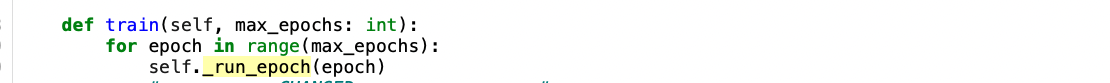 위의 사진에서 보듯이, per epoch으로 돌아가는 것을 볼 수 있다

=> 즉, "one epoch run by one gpu" = "one `_run_epoch` run by one gpu"인데,

**for every one epoch**:
* "train" is run **TWICE** 
    * with different rank (`self.gpu_id`)) and ALSO (different `self.train_data`)



=> when two gpus are used, each `_run_epoch` are run twice, but with different `self.gpu_id` values (i.e. different rank) => this also means two 


### 2.2.2. 코드가 구체적으로 돌아가는 **과정들** (example with two gpus)

#### 1. `mp.spawn`으로,`nprocs=world_size`의 갯수만큼 process (multiprocess)가 spawn

> ```python
if __name__ == "__main__":
    ##(중간생략)###
    world_size = torch.cuda.device_count()
    mp.spawn(main, args=(world_size, args.save_every, args.total_epochs, args.batch_size), nprocs=world_size)```



> * 여기서 : `main`이라는 함수가 2개가 돌아간다 (two processes are "spawned"). 
> * **어떻게 돌아가냐 :  `main(i, *args)`로 돌아간다.** 
    * `i` : rank (`mp.spawn`이 알아서 배정)(process index)
    * `*args` : 이미 `args=`로 `mp.spawn`할때 제공한 것들 
        * (즉, main 함수 돌릴때 input들이 : `mp.spawn`에서 지정해준 `args`는 모든 process에서 똑같지만, rank값을 맨 앞의 input으로 넣는다. 
        * (따라서, main함수에서는 무조건 맨 앞에 rank #를 받도록 해야할듯(?) (**ASK**)
> * 즉, **`main`을 여러번 돌리되, 돌릴때 마다 rank # 만 다르게 input으로 넣는다** => 중요
    * 그러면, 이 main은 어떤 함수길래? (2.에 나옴)

#### 2. `main` 함수를 두번돌리기 (with different rank values)

> ```python
def main(rank: int, world_size: int, save_every: int, total_epochs: int, batch_size: int):
    ddp_setup(rank, world_size)   
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size) #modified dataloader due to different sampler
    trainer = Trainer(model, train_data, optimizer, rank, save_every) #이것도 'device'에서 'rank'로 바뀜 
    trainer.train(total_epochs)
    destroy_process_group()                
    #added to destroy the process group once it's done
```


>**steps (위의 코드 설명):**

>0. `main`함수에서, 앞서 말했듯이, rank값과 나머지 args를 받는다
    *  여기서 받은 rank 값을 밑에 dataloading등등을 할때 pass해준다 (그래야 다른 데이터가 로딩되고, 등등 되니)
    
>1. `ddp_setup(rank, world_size)`로 "distributed process group"를 initialize한다 
    * 이때, rank를 넣어줘서, 어떤 process를 하는지 지정해준다
    * `ddp_setup`은 다음을 한다 (코드 보면 나옴):
        * `os.environ`에서 `MASTER_ADDR, MASTER_PORT`, 을 `localhost, 12355`로 지정해준다
        * `init_process_group(backend="nccl", rank=rank, world_size=world_size)`를 해서, 해당 rank의 process_group을 initialize한다 (?)(?) (**ASK**)
            * 이, "distirbuted process group"이 나중에 DistributedSampler에서 쓰이는 듯? (or else, 어떻게 rank값을 안받고도 split하는 방법을 알겠노...)
            * **(ASK) : 이 파트잘 이해 안됨, (process group part), 질문하기!!**

>2. `dataset, model, optimizer = load_train_objs()`로 "일반적인" dataset, model, optimizer을 가져온다 
    * 일반 (**one-gpu**와 똑같은) dataset, model, optimizer을 가져오기 (**same for all processes (gpus)**(코드 보면 알 수 있다))

>3. `train_data = prepare_dataloader(dataset, batch_size)`로, RANK에 맞는 sampler이 들어간 dataloader을 가져온다
    * 즉, **dataset은 동일**하지만, dataloader 파트에서 `DistributedSampler`을 써서 **process(rank)마다 다른 mini-batch**를 받도록 한다! (밑에 보기)
    * `prepare_dataloader`의 구체적인 작동원리 : 
        * 코드 
>> ```python
>>def prepare_dataloader(dataset: Dataset, batch_size: int):
>>    return DataLoader(
>>        dataset, batch_size=batch_size, pin_memory=True,
>>        shuffle=False, #changed bc sample distirbuted by DistributedSampler
>>        sampler=DistributedSampler(dataset)   #added so that we can divide the batch and send it to each processes )
>>    ```
        * 설명 : 
            * 즉, rank를 직접 지정해주지 않지만, `DistributedSampler`이 dataset을 받아서, (rank에 대한 정보가 input으로 주어지지 않았는데도(?)) 자동으로 rank에 맞게 mini-batch/sampling을 rank들 한테 시키는듯? 
            * **ASK** 잘 이해안됨 (어떻게 rank정보없이 `DistributedSampler`은 알아서 rank들한테 알맞은 것을 배정해주지?
            

> 4. `trainer = Trainer(model, train_data, optimizer, rank, save_every)`:  `Trainer`을 먼저 instantiate하기 
    * 여기서 불러오는 Trainer이, instantiate될때 어떻게 되는건지 보자 : 
>> <details>
>> <summary> `Trainer` class 코드</summary>
>>
>> ```python
>> class Trainer:
>>    def __init__(
>>        self,
>>        model: torch.nn.Module,
>>        train_data: DataLoader,
>>        optimizer: torch.optim.Optimizer,
>>        gpu_id: int,
>>        save_every: int,
>>    ) -> None:
>>        
>>        self.gpu_id = gpu_id
>>        self.model = model.to(gpu_id)
>>        self.train_data = train_data
>>        self.optimizer = optimizer
>>        self.save_every = save_every
>>        
>>        #==========ADDED=================#
>>        self.model = DDP(model, device_ids=[gpu_id]) #wrap it with DDP before running the model
>>                                    #device_ids : list of gpu ids that the model lives on ([0,1] in our case)
>>        #===================================#       
>> ```
>> </details>
    * 위의 코드에서 핵심 : `self.model = DDP(model, device_ids=[gpu_id])`
        * 즉, `Trainer`이 (single-gpu)`model`와 `gpu_id`(gpu정보)를 받아서, **`DDP`를 wrapping해서 DDP version model로 만든다!**

> 5. `trainer.train(total_epochs)`로 train method를 실시하기
    * 이렇게 하면, 앞에서 정의한 `trainer` instance 의 `train()` method를 불러오게 된다   
>> <details>
>> <summary> `Trainer` class 코드</summary>
>>
>> ```python
>>    def train(self, max_epochs: int):
>>        for epoch in range(max_epochs):
>>            self._run_epoch(epoch)
>>            if self.gpu_id == 0 and epoch % self.save_every == 0:
>>                self._save_checkpoint(epoch) 
>> ```
>> </details>
    * 즉, 위에서 하는 것 : 
        * `self._run_epoch(epoch)`으로, 해당 `epoch`을 돌리기
        * `self.gpu_id ==0`이고 (즉, 똑같은 process여러개 하는데 그중 하나만 우리는 상관한다) AND 특정 epoch일때, save한다
    * `_run_epoch`에 관해서 : 
>> <details>
>> <summary> `_run_epoch` 코드</summary>
>>
>>```python
>>    def _run_epoch(self, epoch):
>>        b_sz = len(next(iter(self.train_data))[0]) #batch size가 vary by how much gpu we use
>>        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
>>        
>>        self.train_data.sampler.set_epoch(epoch) #has to be added because if not, the same ordering will be used in each epoch => 이해 잘 안됨!
>>        for source, targets in self.train_data:
>>            source = source.to(self.gpu_id)
>>            targets = targets.to(self.gpu_id)
>>            self._run_batch(source, targets)
>> ```
>> </details>
    * 즉, 위에서 보듯이 
        * `self.train_data.sampler.set_epoch(epoch)`으로 epoch이런거 한다고 하는데, 잘 이해가 안됨!! => **ASK**
        * `XXX.to(self.gpu_id)`로, 해당 gpu로 보낸다! (그냥 `cuda:0`으로 보내는게 아님!)
        * `_run_batch`로, 해당 GPU로 보낸 source (input), targets (output)을 가지고 training하기! (`_run_batch`는 생략!)

> 6. `destroy_process_group()`로, process group을 destroy하기!
    * 이것 구체적으로 어떻게 되는거고 뭐하는 건지 잘 모르겠다..ㅋㅋㅋㅋ **ASK**

## 2.3. torchrun으로 multigpu를 돌려보자 (still one node)

In [13]:
import os
os.environ

environ{'SHELL': '/bin/bash',
        'SLURM_STEP_NUM_TASKS': '1',
        'SLURM_JOB_USER': 'dyhan316',
        'SLURM_TASKS_PER_NODE': '1',
        'SLURM_JOB_UID': '10033',
        'SLURM_STEP_GPUS': '5,7',
        'SLURM_CPU_BIND': 'quiet,mask_cpu:0x000000001E00000000001E00',
        'SLURM_TASK_PID': '4097',
        'CONDA_EXE': '/usr/anaconda3/bin/conda',
        '_CE_M': '',
        'SLURM_LOCALID': '0',
        'SLURM_SUBMIT_DIR': '/scratch/connectome/dyhan316',
        'SLURM_CPU_BIND_VERBOSE': 'quiet',
        'SLURMD_NODENAME': 'node3',
        'SLURM_STEP_NODELIST': 'node3',
        'SLURM_CLUSTER_NAME': 'cluster',
        'SLURM_CPUS_ON_NODE': '8',
        'SLURM_UMASK': '0022',
        'SLURM_JOB_CPUS_PER_NODE': '8',
        'PWD': '/scratch/connectome/dyhan316',
        'SLURM_GTIDS': '0',
        'LOGNAME': 'dyhan316',
        'XDG_SESSION_TYPE': 'tty',
        'CONDA_PREFIX': '/home/connectome/dyhan316/.conda/envs/VAE_3DCNN',
        'SLURM_JOB_PARTITION': 'debug',
   

In [16]:
! scontrol show hostnames node1

node1


In [18]:
os.getenv('SLURM_NODEID'), os.getenv('SLURM_NNODES')


('0', '1')

# ASK THE THINGS ABOVE!!

In [ ]:
a, c

### must study : 
* multiprocessing in python (especially "spwan") (http://localhost:10033/notebooks/ML_tutor/barlow_twins_supplementary_knowledge/IMP_python_prereqs.ipynb 여기다가 정리해놓기)

* torch saving : http://localhost:10033/notebooks/ML_tutor/barlow_twins_supplementary_knowledge/PyTorch_other_supplementary.ipynb

이것들을 보아야 일단 배경짓기이 완성이 될듯

In [ ]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [ ]:
help(DistributedSampler)

In [ ]:
help(init_process_group)